In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

### Decision Tree Classifier

In [3]:
class CustomDecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None
    # Build the decision tree
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
        
    # Predict class for each sample in X
    def predict(self, X):
        return np.array([self._classify(x, self.tree) for x in X])

    # Stop conditions: max depth reached or no samples left
    def _build_tree(self, X, y, depth):
        if len(y) == 0 or depth == self.max_depth:
            # If no samples or max depth reached, return the most frequent class
            return np.argmax(np.bincount(y)) if len(y) > 0 else None

        # Find the best feature and threshold for splitting
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            # If no valid split, return the most frequent class
            return np.argmax(np.bincount(y))

        # Split data into left and right subsets
        left_idx = X[:, best_feature] < best_threshold
        right_idx = ~left_idx

        # Handle empty left or right split
        if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
            return np.argmax(np.bincount(y))  # Return the most frequent class

        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        # Return the node as a dictionary
        return {'feature': best_feature,
                'threshold': best_threshold,
                'left': left_subtree,
                'right': right_subtree}

    # Iterate through features and thresholds to find the best split
    def _best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X[:, feature], y, threshold)
                if gain > best_gain:
                    best_gain, best_feature, best_threshold = gain, feature, threshold
        return best_feature, best_threshold

    # Calculate entropy-based information gain for a split
    def _information_gain(self, X_feature, y, threshold):
        parent_entropy = self._entropy(y)
        left_idx = X_feature < threshold
        right_idx = ~left_idx
        if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
            return 0
        n = len(y)
        n_left, n_right = len(y[left_idx]), len(y[right_idx])
        e_left, e_right = self._entropy(y[left_idx]), self._entropy(y[right_idx])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right
        return parent_entropy - child_entropy

    # Calculate entropy of a label distribution
    def _entropy(self, y):
        proportions = np.bincount(y) / len(y)
        return -np.sum([p * np.log2(p) for p in proportions if p > 0])

    # Traverse the tree to classify a single sample
    def _classify(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature, threshold = tree['feature'], tree['threshold']
        if x[feature] < threshold:
            return self._classify(x, tree['left'])
        return self._classify(x, tree['right'])

### Random Forest Classifier

In [5]:
class CustomRandomForest:
    def __init__(self, n_estimators=100, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    # Train multiple decision trees on random subsets of data
    def fit(self, X, y):
        for _ in range(self.n_estimators):
            idxs = np.random.choice(len(X), size=len(X), replace=True)
            X_sample, y_sample = X[idxs], y[idxs]
            tree = CustomDecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    # Aggregate predictions from all trees
    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_predictions)

### Naive Bayes Classifier

In [7]:
class CustomNaiveBayes:
    def __init__(self):
        self.class_probs = {}
        self.feature_probs = {}

    # Calculate class probabilities P(y)
    def fit(self, X, y):
        self.class_probs = {cls: np.mean(y == cls) for cls in np.unique(y)}
        
        # Calculate feature probabilities P(x|y) for each class
        self.feature_probs = {}
        for cls in np.unique(y):
            X_class = X[y == cls]
            feature_probs_class = []
            for feature_idx in range(X.shape[1]):
                # Calculate mean and std deviation for each feature in each class
                mean = np.mean(X_class[:, feature_idx])
                std = np.std(X_class[:, feature_idx])
                feature_probs_class.append((mean, std))
            self.feature_probs[cls] = feature_probs_class

    # Predict the class label for each sample in X
    def predict(self, X):
        return np.array([self._predict_sample(x) for x in X])

    # Calculate the log-probability for each class
    def _predict_sample(self, x):
        class_scores = {}
        for cls in self.class_probs:
            class_prob = np.log(self.class_probs[cls])
            feature_probs = self.feature_probs[cls]
            # Add the log-likelihood for each feature P(x_i | y)
            for feature_idx, (mean, std) in enumerate(feature_probs):
                feature_prob = self._gaussian_pdf(x[feature_idx], mean, std)
                class_prob += np.log(feature_prob)
            class_scores[cls] = class_prob
        return max(class_scores, key=class_scores.get)

    # Gaussian Probability Density Function
    def _gaussian_pdf(self, x, mean, std):
        return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) ** 2 / std ** 2))

In [8]:
df = pd.read_csv("C:/Users/murar/Downloads/Crop_recommendation.csv")

In [9]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [10]:
X = df.drop(columns=["label"]).to_numpy()
y = df["label"]

In [11]:
# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

#### Decision Tree training

In [14]:
dt_model = CustomDecisionTree(max_depth=10)
dt_model.fit(xtrain, ytrain)
dt_predictions = dt_model.predict(xtest)
print("Decision Tree Classification Report:")
print(classification_report(ytest, dt_predictions))
print("Decision Tree Accuracy:", accuracy_score(ytest, dt_predictions))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      0.96      0.98        26
           4       1.00      0.96      0.98        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.85      0.96      0.90        23
           9       1.00      0.95      0.97        20
          10       0.92      1.00      0.96        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       0.96      0.96      0.96        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.00 

#### Random forest training

In [16]:
rf_model = CustomRandomForest(n_estimators=10, max_depth=10)
rf_model.fit(xtrain, ytrain)
rf_predictions = rf_model.predict(xtest)
print("Random Forest Classification Report:")
print(classification_report(ytest, rf_predictions))
print("Random Forest Accuracy:", accuracy_score(ytest, rf_predictions))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        19
          15       1.00      0.94      0.97        17
          16       1.00      1.00      1.00 

#### Naive Bayes Model training

In [18]:
nb_model = CustomNaiveBayes()
nb_model.fit(xtrain, ytrain)
nb_predictions = nb_model.predict(xtest)
print("Naive Bayes Classification Report:")
print(classification_report(ytest, nb_predictions))
print("Naive Bayes Accuracy:", accuracy_score(ytest, nb_predictions))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.00   

C:\Users\murar\AppData\Local\Temp\ipykernel_18512\722749994.py:35: RuntimeWarning: divide by zero encountered in log
  class_prob += np.log(feature_prob)


In [19]:
data = np.array([[104, 18, 30, 23.603016, 60.3, 6.7, 140.91]])
# Make predictions using the Naive Bayes model (because it has maximum accuracy)
prediction = nb_model.predict(data)
predicted_class = label_encoder.inverse_transform([prediction])
print("Predicted Class for the given data:", predicted_class)

Predicted Class for the given data: ['coffee']


C:\Users\murar\AppData\Local\Temp\ipykernel_18512\722749994.py:35: RuntimeWarning: divide by zero encountered in log
  class_prob += np.log(feature_prob)
C:\Users\murar\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Confusion Matrix
The confusion matrix shows the number of correct and incorrect predictions made by the classifier compared to the actual outcomes.

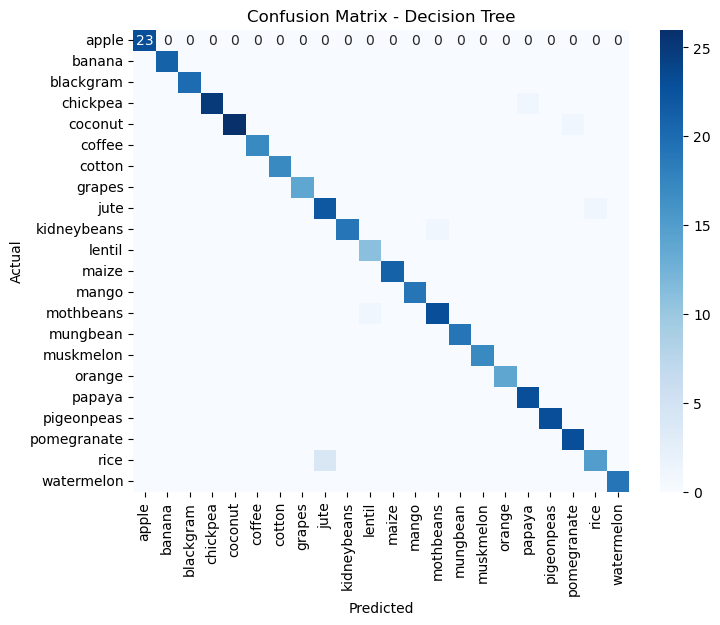

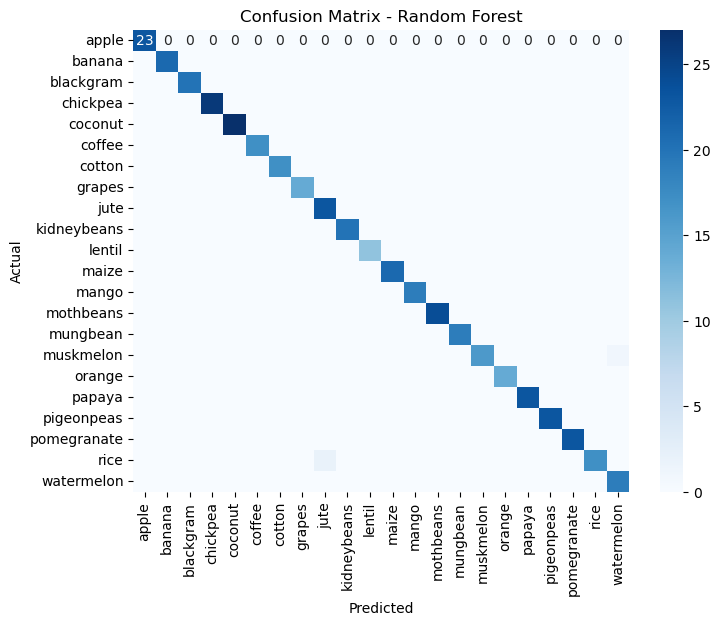

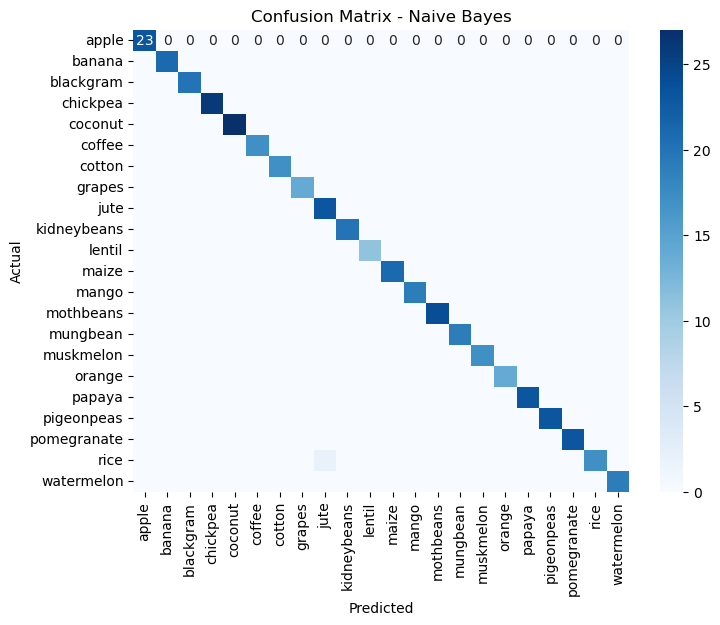

In [21]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
plot_confusion_matrix(ytest, dt_predictions, "Decision Tree")
plot_confusion_matrix(ytest, rf_predictions, "Random Forest")
plot_confusion_matrix(ytest, nb_predictions, "Naive Bayes")

### Prediction Distribution (Naive Bayes)
Since Naive Bayes is based on the Gaussian distribution, it can be helpful to visualize the feature distributions.

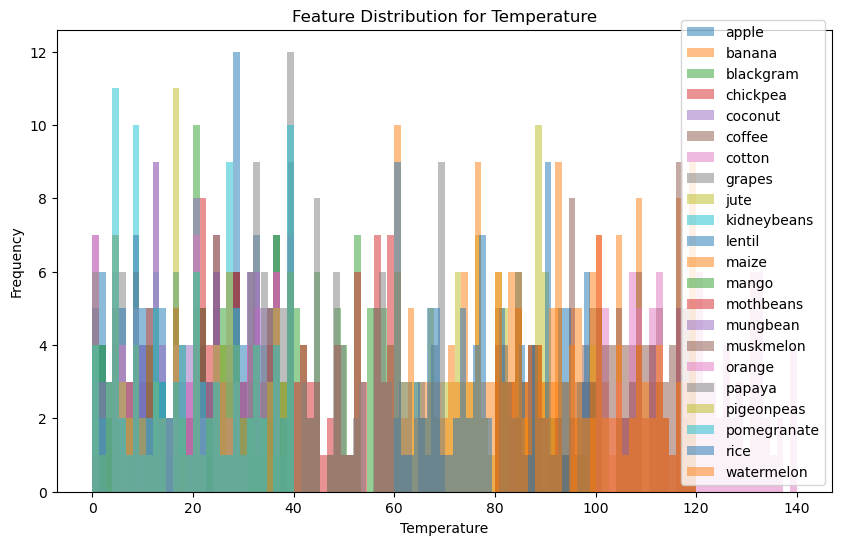

In [23]:
class_names = label_encoder.classes_
def plot_feature_distribution(X, y, feature_idx, feature_name):
    plt.figure(figsize=(10, 6))
    for cls in np.unique(y):
        plt.hist(X[y == cls, feature_idx], bins=30, alpha=0.5, label=f"{class_names[cls]}")
    plt.title(f"Feature Distribution for {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
plot_feature_distribution(X, y_encoded, 0, "Temperature")

In [39]:
import joblib
joblib.dump(nb_model, 'naive_bayes_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']